Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Evaluation code


__Disclaimer__
*   This notebook contains experimental code, which may be changed without notice.
*   The ideas here are some ideas relevant to fairness - they are not the whole story!



# Notebook summary

This notebook intends to evaluate a list of models on two dimensions:
- "Performance": How well the model perform to classify the data (intended bias). Currently, we use the AUC.
- "Bias": How much bias does the model contain (unintended bias). Currently, we use the pinned auc.

This script takes the following steps:

- Write input function to generate 2 datasets:
    - A "performance dataset" which will be used for the first set of metrics. This dataset is supposed to be similar format to the training data (contain a piece of text and a label).
    - A "bias dataset" which will be used for the second set of metrics. This data contains a piece of text, a label but also some subgroup information to evaluate the unintended bias on.
- Runs predictions with the export_utils.
- Evaluate metrics.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import getpass
from IPython.display import display
import json
import nltk
import numpy as np
import pandas as pd
import pkg_resources
import os
import random
import re
import seaborn as sns

import tensorflow as tf
from tensorflow.python.lib.io import file_io

In [4]:
from utils_export.dataset import Dataset, Model
from utils_export import utils_cloudml
from utils_export import utils_tfrecords

In [5]:
os.environ['GCS_READ_CACHE_MAX_SIZE_MB'] = '0' #Faster to access GCS file + https://github.com/tensorflow/tensorflow/issues/15530

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /usr/local/google/home/lucyvasserman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Settings

### Global variables

In [7]:
# User inputs
PROJECT_NAME = 'wikidetox'

# Information about deployed model.
MODEL_NAMES = [
    'tf_gru_attention_unbiasN_trainY:v_1537919376',
    'tf_gru_attention_unbiasY_trainN:v_1537918796']

# Model description
TEXT_FEATURE_NAME = 'comment_text' #Input text
SENTENCE_KEY = 'comment_key' #Input key
LABEL_NAME_PREDICTION_MODEL = 'frac_neg/logistic' # Output prediction

# Part 1: Creating input_fn

In [8]:
def tokenizer(text, lowercase=True):
  """Converts text to a list of words.

  Args:
    text: piece of text to tokenize (string).
    lowercase: whether to include lowercasing in preprocessing (boolean).
    tokenizer: Python function to tokenize the text on.

  Returns:
    A list of strings (words).
  """
  words = nltk.word_tokenize(text.decode('utf-8'))
  if lowercase:
    words = [w.lower() for w in words]
  return words

### Toxicity 2017 performance dataset

In [9]:
# User inputs
TOXICITY_PERFORMANCE_DATASET = 'gs://kaggle-model-experiments/resources/toxicity_q42017_test.tfrecord'
TOXICITY_DATA_LABEL = 'frac_neg' #Name of the label in the performance dataset

# DECODING
decoding_input_features = {
  TEXT_FEATURE_NAME: tf.FixedLenFeature([], dtype=tf.string),
  TOXICITY_DATA_LABEL: tf.FixedLenFeature([], dtype=tf.float32)
}

def input_fn_performance_toxicity(max_n_examples=None, random_filter_keep_rate=1.0):
    res = utils_tfrecords.decode_tf_records_to_pandas(
        decoding_input_features,
        TOXICITY_PERFORMANCE_DATASET,
        max_n_examples,
        random_filter_keep_rate)
    res[TEXT_FEATURE_NAME] = list(map(tokenizer, res[TEXT_FEATURE_NAME]))
    res = res.rename(columns={
        TOXICITY_DATA_LABEL: 'label'})
    res['label'] = list(map(lambda x: bool(round(x)), list(res['label'])))
    final = res.copy(deep=True)
    return final

### Civil comments performance dataset

In [10]:
CIVIL_COMMENTS_PATH = 'gs://kaggle-model-experiments/resources/civil_comments_data/train.tfrecord'
THRESHOLD_BIAS_CIVIL = 0.5

civil_comments_spec = {
    'comment_text': tf.FixedLenFeature([], dtype=tf.string),
    'id': tf.FixedLenFeature([], dtype=tf.string),
    'toxicity': tf.FixedLenFeature([], dtype=tf.float32),
    'severe_toxicity': tf.FixedLenFeature([], dtype=tf.float32),
    'obscene': tf.FixedLenFeature([], dtype=tf.float32),
    'sexual_explicit': tf.FixedLenFeature([], dtype=tf.float32),
    'identity_attack': tf.FixedLenFeature([], dtype=tf.float32),
    'insult': tf.FixedLenFeature([], dtype=tf.float32),
    'threat': tf.FixedLenFeature([], dtype=tf.float32),
    'toxicity_annotator_count': tf.FixedLenFeature([], dtype=tf.int64),
    'identity_annotator_count': tf.FixedLenFeature([], dtype=tf.int64),
    'male': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'female': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'transgender': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'other_gender': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'heterosexual': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'homosexual_gay_or_lesbian': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'bisexual': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'other_sexual_orientation': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'christian': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'jewish': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'muslim': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'hindu': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'buddhist': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'atheist': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'other_religion': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'black': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'white': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'asian': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'latino': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'other_race_or_ethnicity': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'physical_disability': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'intellectual_or_learning_disability': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'psychiatric_or_mental_illness': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
    'other_disability': tf.FixedLenFeature([], dtype=tf.float32, default_value=-1.),
}

identity_terms_civil = ['male', 'female', 'transgender', 'other_gender', 'heterosexual', 
                        'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation',
                        'christian', 'jewish', 'muslim', 'hindu', 'buddhist', 'atheist',
                        'other_religion', 'black', 'white', 'asian', 'latino', 'other_race_or_ethnicity',
                        'physical_disability', 'intellectual_or_learning_disability',
                        'psychiatric_or_mental_illness', 'other_disability'
                       ]

In [11]:
def input_fn_performance_civil(max_n_examples=None, random_filter_keep_rate=1.0):
    civil_df_raw = utils_tfrecords.decode_tf_records_to_pandas(
        civil_comments_spec,
        CIVIL_COMMENTS_PATH,
        max_n_examples=max_n_examples,
        random_filter_keep_rate=random_filter_keep_rate,
    )
    civil_df_raw[TEXT_FEATURE_NAME] = list(map(tokenizer, civil_df_raw[TEXT_FEATURE_NAME]))
    civil_df_raw['toxicity'] = list(map(lambda x: bool(round(x)), list(civil_df_raw['toxicity'])))
    civil_df_raw = civil_df_raw.rename(columns={
        'comment_text': TEXT_FEATURE_NAME,
        'toxicity': 'label'})
    res = civil_df_raw.copy(deep=True)
    return res

### Synthetic comment bias dataset

In [12]:
!pip install -U -q -e git+https://github.com/conversationai/unintended-ml-bias-analysis

Could not detect requirement name for 'git+https://github.com/conversationai/unintended-ml-bias-analysis', please specify one with #egg=your_package_name


In [13]:
from unintended_ml_bias import model_bias_analysis

In [14]:
# Loading it from it the unintended_ml_bias github.
entire_test_bias_df = pd.read_csv(
    pkg_resources.resource_stream("unintended_ml_bias", "eval_datasets/bias_madlibs_77k.csv"))
entire_test_bias_df['raw_text'] = entire_test_bias_df['Text']
entire_test_bias_df['label'] = entire_test_bias_df['Label']
entire_test_bias_df['label'] = list(map(lambda x: x=='BAD', entire_test_bias_df['label']))
entire_test_bias_df = entire_test_bias_df[['raw_text', 'label']].copy()
identity_terms_synthetic = [line.strip()
         for line in pkg_resources.resource_stream("unintended_ml_bias", "bias_madlibs_data/adjectives_people.txt")]
model_bias_analysis.add_subgroup_columns_from_text(entire_test_bias_df, 'raw_text', identity_terms_synthetic)
# Add preprocessing
entire_test_bias_df['text'] = list(map(tokenizer, entire_test_bias_df['raw_text']))

In [15]:
def input_fn_bias(max_n_examples):
    if max_n_examples:
        res = entire_test_bias_df.sample(n=max_n_examples, random_state=2018)
    else:
        res = entire_test_bias_df
    res = res.copy(deep=True)
    res = res.rename(
        columns={
            'raw_text': TEXT_FEATURE_NAME
        })
    return res

### Civil comment bias dataset

Construction of this database such as:
- we keep only examples that have identity labels (with rule: male >=0)
- we apply the 'threshold_bias_civil' for each identity field
- we select x% of the "background", i.e. examples that are 0 for each identify. 
Indeed, as the background is dominant, we want to reduce the size of the test set.  

In [16]:
def filter_fn_civil(example, background_filter_keep_rate=0.1):
    if example ['male'] < 0.:
        return False
    contains_one_identity = False
    for _term in identity_terms_civil:
        if example[_term] >= THRESHOLD_BIAS_CIVIL:
            contains_one_identity = True
    if contains_one_identity:
        return True
    else:
        return (random.random() < background_filter_keep_rate)

def input_fn_bias_civil(max_n_examples=None):
    civil_df_raw = utils_tfrecords.decode_tf_records_to_pandas(
        civil_comments_spec,
        CIVIL_COMMENTS_PATH,
        max_n_examples=max_n_examples,
        filter_fn=filter_fn_civil,
    )
    civil_df_raw[TEXT_FEATURE_NAME] = list(map(tokenizer, civil_df_raw[TEXT_FEATURE_NAME]))
    for _term in identity_terms_civil:
        civil_df_raw[_term] = list(map(lambda x : x >= THRESHOLD_BIAS_CIVIL, list(civil_df_raw[_term])))
    civil_df_raw['toxicity'] = list(map(lambda x: bool(round(x)), list(civil_df_raw['toxicity'])))
    civil_df_raw = civil_df_raw.rename(columns={
        'comment_text': TEXT_FEATURE_NAME,
        'toxicity': 'label'})
    res = civil_df_raw.copy(deep=True)
    return res

# Part 2: Running prediction

### Defining the model

In [17]:
# User inputs.
model_input_spec = {
    TEXT_FEATURE_NAME: utils_tfrecords.EncodingFeatureSpec.LIST_STRING} #library will use this automatically

model = Model(
    feature_keys_spec=model_input_spec,
    prediction_keys=LABEL_NAME_PREDICTION_MODEL,
    example_key=SENTENCE_KEY,
    model_names=MODEL_NAMES,
    project_name=PROJECT_NAME)

### Performance dataset

In [18]:
# User inputs
SIZE_PERFORMANCE_DATA_SET = 10000

# Pattern for path of tf_records
PERFORMANCE_DATASET_DIR = os.path.join(
    'gs://kaggle-model-experiments/',
    getpass.getuser(),
    'tfrecords',
    'test_performance_toxicity')

In [19]:
dataset_performance = Dataset(input_fn_performance_toxicity, PERFORMANCE_DATASET_DIR)
random.seed(2018) # Need to set seed before loading data to be able to reload same data in the future
dataset_performance.load_data(SIZE_PERFORMANCE_DATA_SET, random_filter_keep_rate=0.5)

INFO:tensorflow:input_fn is compatible with the `Dataset` class.


/usr/local/google/home/lucyvasserman/conversationai-models/model_evaluation/venv/local/lib/python2.7/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [20]:
# Set recompute_predictions=False to save time if predictions are available.
dataset_performance.add_model_prediction_to_data(model, recompute_predictions=True)

INFO:tensorflow:Model is compatible with the `Dataset` instance.


### Bias dataset

In [21]:
# User inputs
SIZE_BIAS_DATA_SET = 20000

# Pattern for path of tf_records
BIAS_DATASET_DIR = os.path.join(
    'gs://kaggle-model-experiments/',
    getpass.getuser(),
    'tfrecords',
    'test_bias_civil_comments')

In [22]:
dataset_bias = Dataset(input_fn_bias_civil, BIAS_DATASET_DIR)
random.seed(2018) # Need to set seed before loading data to be able to reload same data in the future
dataset_bias.load_data(SIZE_BIAS_DATA_SET)

INFO:tensorflow:input_fn is compatible with the `Dataset` class.


In [23]:
# Set recompute_predictions=False to save time if predictions are available.
dataset_bias.add_model_prediction_to_data(model, recompute_predictions=True)

INFO:tensorflow:Model is compatible with the `Dataset` instance.


### Post processing

In [24]:
test_performance_df = dataset_performance.show_data()

In [25]:
test_bias_df = dataset_bias.show_data()

### Analyzing final results

In [26]:
test_performance_df.head()

,comment_text,label,tf_gru_attention_unbiasN_trainY:v_1537919376,tf_gru_attention_unbiasY_trainN:v_1537918796
0,"[thanks, i, appreciate, your, welcome, to, the...",False,0.000073,0.001292
1,"[sandifer, ,, i, 'm, going, buy, my, way, back...",True,0.009869,0.067003
2,"[``, we, do, n't, keep, non-free, material, ju...",False,0.002010,0.011768
3,"[unblock, and, thanks, ,]",False,0.000069,0.002955
4,"[``, '', '', ..., some, serbs, tried, to, defe...",False,0.003474,0.007628


In [27]:
test_bias_df.head()

,asian,atheist,bisexual,black,buddhist,christian,comment_text,female,heterosexual,hindu,...,psychiatric_or_mental_illness,severe_toxicity,sexual_explicit,threat,label,toxicity_annotator_count,transgender,white,tf_gru_attention_unbiasN_trainY:v_1537919376,tf_gru_attention_unbiasY_trainN:v_1537918796
0,False,False,False,False,False,False,"[so, now, who, will, pay, for, ``, the, wall, ...",False,False,False,...,False,0.0,0.0,0.0,False,4,False,False,0.002755,0.011304
1,False,False,False,False,False,False,"[they, were, attacking, francis, with, their, ...",False,False,False,...,False,0.0,0.0,0.0,False,4,False,False,0.007701,0.047250
2,False,False,False,False,False,True,"[rule, of, law, ?, you, mean, ,, which, allowe...",False,False,False,...,False,0.0,0.0,0.0,False,4,False,False,0.015580,0.019242
3,False,False,False,False,False,False,"[please, tell, us, why, you, trust, the, inter...",False,False,False,...,False,0.0,0.0,0.0,False,4,False,True,0.004191,0.017925
4,False,False,False,False,False,True,"[i, see, no, sub-text, unless, it, is, amidst,...",False,False,False,...,False,0.0,0.0,0.0,False,4,False,False,0.034341,0.092397


# Part 3: Run evaluation metrics

## Performance metrics

### Data Format

At this point, our performance data is in DataFrame df, with columns:

- label: True if the comment is Toxic, False otherwise.
- < model name >: One column per model, cells contain the score from that model.
You can run the analysis below on any data in this format. Subgroup labels can be generated via words in the text as done above, or come from human labels if you have them.

### Run AUC

In [28]:
import sklearn.metrics as metrics

In [29]:
auc_list = []
for _model in MODEL_NAMES:
  fpr, tpr, thresholds = metrics.roc_curve(
      test_performance_df['label'],
      test_performance_df[_model])
  auc_list.append(metrics.auc(fpr, tpr))
print ('Auc for model {}: {}'.format(_model, np.mean(auc_list)))

Auc for model tf_gru_attention_unbiasY_trainN:v_1537918796: 0.91155229286


## Unintended Bias Metrics

### Data Format
At this point, our bias data is in DataFrame df, with columns:

*   label: True if the comment is Toxic, False otherwise.
*   < model name >: One column per model, cells contain the score from that model.
*   < subgroup >: One column per identity, True if the comment mentions this identity.

You can run the analysis below on any data in this format. Subgroup labels can be 
generated via words in the text as done above, or come from human labels if you have them.


In [30]:
identity_terms_civil_included = []
for _term in identity_terms_civil:
    if sum(test_bias_df[_term]) >= 20:
        print ('keeping {}'.format(_term))
        identity_terms_civil_included.append(_term)

keeping male
keeping female
keeping transgender
keeping heterosexual
keeping homosexual_gay_or_lesbian
keeping bisexual
keeping christian
keeping jewish
keeping muslim
keeping hindu
keeping buddhist
keeping atheist
keeping other_religion
keeping black
keeping white
keeping asian
keeping latino
keeping other_race_or_ethnicity
keeping psychiatric_or_mental_illness


In [31]:
bias_metrics = model_bias_analysis.compute_bias_metrics_for_models(test_bias_df, identity_terms_civil_included, MODEL_NAMES, 'label')

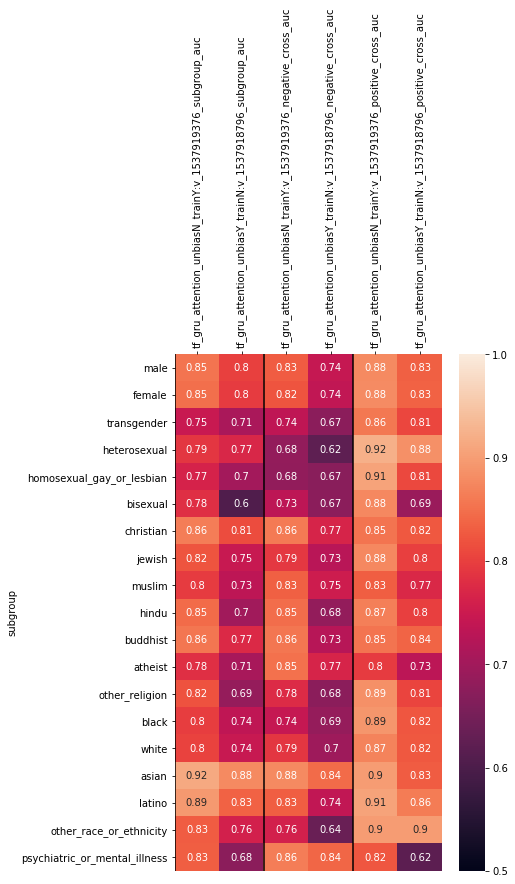

In [32]:
model_bias_analysis.plot_auc_heatmap(bias_metrics, MODEL_NAMES)

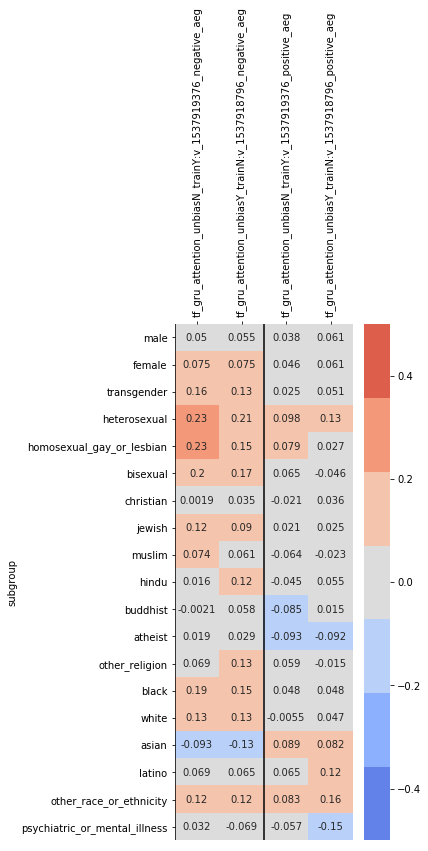

In [33]:
model_bias_analysis.plot_aeg_heatmap(bias_metrics, MODEL_NAMES)